<a href="https://colab.research.google.com/github/crystalclcm/APA-Poster-Project/blob/main/APA_Poster1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Imports
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix
)

from google.colab import drive

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [3]:
#NLTK Download
nltk.download('punkt_tab')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
#Mount google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#File path
file_path = '/content/drive/MyDrive/Openfood.tsv'

In [6]:
#Read dataset
df_full = pd.read_csv(file_path, sep='\t', compression='infer',
                      low_memory=True)


/tmp/ipython-input-2555730610.py:2: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df_full = pd.read_csv(file_path, sep='\t', compression='infer',


In [7]:
#Create sample of 250,000 rows
sample_size = 250_000
sample_df = df_full.sample(n=sample_size, random_state=42)

print("Sampled dataset shape:", sample_df.shape)

Sampled dataset shape: (250000, 163)


In [8]:
#Keep relevent columns
cols_keep = [
    "product_name",
    "ingredients_text",
    "sugars_100g",
    "saturated-fat_100g",
    "energy_100g"
]

df = sample_df[cols_keep].copy()

In [9]:
#Fill missing names and ingredients with empty strings
df["product_name"] = df["product_name"].fillna("")
df["ingredients_text"] = df["ingredients_text"].fillna("")

In [10]:
#Combine into a single text field
df["text"] = (df["product_name"] + " " + df["ingredients_text"]).str.strip()

In [11]:
#Drop rows without text
df = df[df["text"] != ""].reset_index(drop=True)
print("After removing empty text rows:", df.shape)

After removing empty text rows: (238902, 6)


In [12]:
#Traffic light labelling for sugar
def traffic_light_sugar(s):
    if pd.isna(s):
        return None
    if s <= 5.0:
        return "green"   #low sugar
    elif s <= 22.5:
        return "amber"   #medium sugar
    else:
        return "red"     #high sugar


In [13]:
#Traffic light labelling for sat fat
def traffic_light_satfat(sat):
    if pd.isna(sat):
        return None
    if sat <= 1.5:
        return "green"   #low sat fat
    elif sat <= 5.0:
        return "amber"   #medium sat fat
    else:
        return "red"     #high sat fat

df["sugar_tl"] = df["sugars_100g"].apply(traffic_light_sugar)
df["satfat_tl"] = df["saturated-fat_100g"].apply(traffic_light_satfat)

In [14]:
#Use of labels
def make_label_from_traffic(row):
    sugar = row["sugar_tl"]
    sat   = row["satfat_tl"]

    if sugar is None or sat is None:
        return np.nan

    # Any red = unhealthy
    if sugar == "red" or sat == "red":
        return 0

    # Both green = clearly healthy
    if sugar == "green" and sat == "green":
        return 1

    # Amber / mixed cases = borderline
    return np.nan

df["label"] = df.apply(make_label_from_traffic, axis=1)


In [15]:
#Keep labelled rows only
df_model = df.dropna(subset=["label"]).copy()
df_model["label"] = df_model["label"].astype(int)

print("Labelled dataset shape:", df_model.shape)
print("Label distribution:\n", df_model["label"].value_counts())

Labelled dataset shape: (124953, 9)
Label distribution:
 label
0    79135
1    45818
Name: count, dtype: int64


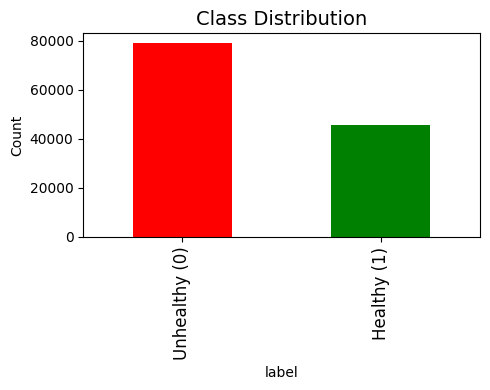

In [16]:
#Class distribution
plt.figure(figsize=(5, 4))
df_model["label"].value_counts().sort_index().plot(
    kind="bar", color=["red", "green"]
)
plt.xticks([0, 1], ["Unhealthy (0)", "Healthy (1)"], fontsize=12)
plt.title("Class Distribution", fontsize=14)
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/poster_class_distribution.png", dpi=300)
plt.show()

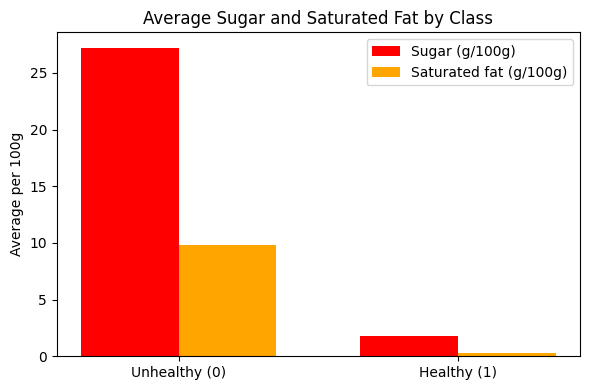

In [17]:
#Average sugar and saturated fat per class
avg_values = df_model.groupby('label')[['sugars_100g', 'saturated-fat_100g']].mean()

classes = ['Unhealthy (0)', 'Healthy (1)']
sugar_means = avg_values['sugars_100g'].values
satfat_means = avg_values['saturated-fat_100g'].values

x = range(len(classes))
width = 0.35

plt.figure(figsize=(6, 4))
plt.bar(x, sugar_means, width, label='Sugar (g/100g)', color='red')
plt.bar([i + width for i in x], satfat_means, width,
        label='Saturated fat (g/100g)', color='orange')

plt.xticks([i + width/2 for i in x], classes)
plt.ylabel('Average per 100g')
plt.title('Average Sugar and Saturated Fat by Class')
plt.legend()
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/poster_avg_nutrients.png', dpi=300)
plt.show()

In [18]:
#Text preprocessing and train–test split
def clean_text(text):
    text = str(text).lower()
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.isalnum()]
    tokens = [t for t in tokens if t not in stop_words]
    return " ".join(tokens)

df_model["clean_text"] = df_model["text"].apply(clean_text)

X = df_model["clean_text"]
y = df_model["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

Train size: 99962
Test size: 24991


In [19]:
#TF-IDF vectorisation
tfidf = TfidfVectorizer(
    max_features=15_000,
    ngram_range=(1, 2),
    stop_words='english'
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

print("TF–IDF shapes:", X_train_tfidf.shape, X_test_tfidf.shape)

TF–IDF shapes: (99962, 15000) (24991, 15000)


In [20]:
#Logistic Regression and Linear SVM
log_model = LogisticRegression(
    max_iter=300,
    class_weight='balanced'
)
log_model.fit(X_train_tfidf, y_train)
log_pred = log_model.predict(X_test_tfidf)

print("\nLogistic Regression")
print(classification_report(y_test, log_pred, digits=2))

#Linear SVM with class weights
svm_model = LinearSVC(class_weight='balanced')
svm_model.fit(X_train_tfidf, y_train)
svm_pred = svm_model.predict(X_test_tfidf)

print("\nLinear SVM")
print(classification_report(y_test, svm_pred, digits=2))


Logistic Regression
              precision    recall  f1-score   support

           0       0.97      0.92      0.94     15827
           1       0.87      0.94      0.91      9164

    accuracy                           0.93     24991
   macro avg       0.92      0.93      0.93     24991
weighted avg       0.93      0.93      0.93     24991


Linear SVM
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     15827
           1       0.89      0.94      0.92      9164

    accuracy                           0.94     24991
   macro avg       0.93      0.94      0.93     24991
weighted avg       0.94      0.94      0.94     24991



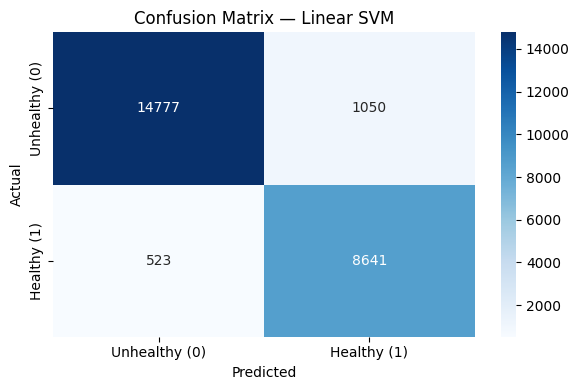

In [ ]:
#Confusion Matrix
cm = confusion_matrix(y_test, svm_pred)
labels = ["Unhealthy (0)", "Healthy (1)"]

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix — Linear SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/poster_confusion_svm.png', dpi=300)
plt.show()

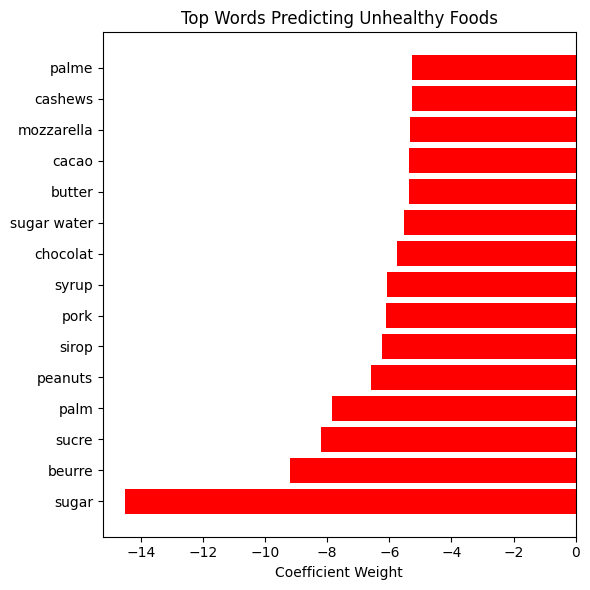

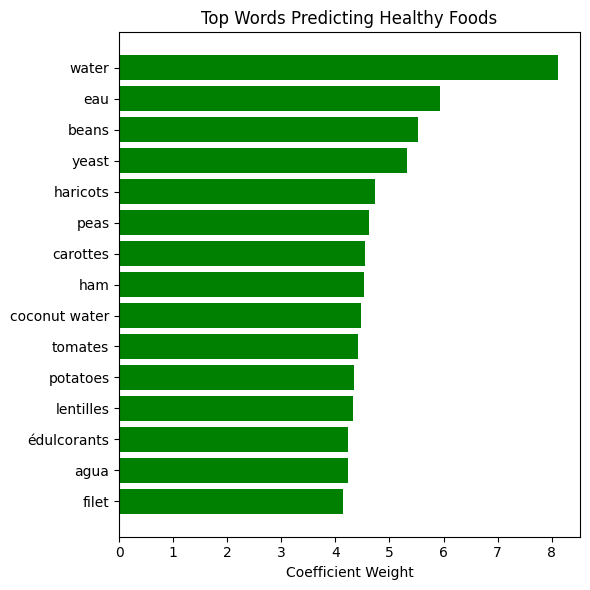

In [ ]:
#Top Predictive Words
feature_names = np.array(tfidf.get_feature_names_out())
coef = log_model.coef_[0]

#Top 15 words predicting Unhealthy
top_unhealthy_idx = np.argsort(coef)[:15]
top_unhealthy_words = feature_names[top_unhealthy_idx]
top_unhealthy_values = coef[top_unhealthy_idx]

plt.figure(figsize=(6,6))
plt.barh(top_unhealthy_words, top_unhealthy_values, color='red')
plt.title("Top Words Predicting Unhealthy Foods")
plt.xlabel("Coefficient Weight")
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/poster_unhealthy_words.png', dpi=300)
plt.show()

#Top 15 words predicting Healthy
top_healthy_idx = np.argsort(coef)[-15:]
top_healthy_words = feature_names[top_healthy_idx]
top_healthy_values = coef[top_healthy_idx]

plt.figure(figsize=(6,6))
plt.barh(top_healthy_words, top_healthy_values, color='green')
plt.title("Top Words Predicting Healthy Foods")
plt.xlabel("Coefficient Weight")
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/poster_healthy_words.png', dpi=300)
plt.show()
